In [56]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import scipy.signal as sciSig

# Load Image and Display


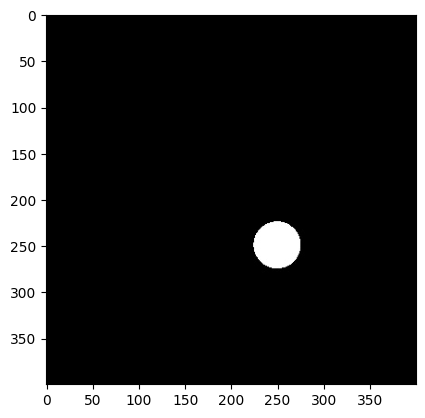

In [57]:
def load_image(path):
    return np.array(Image.open(path).convert('L'))

image_array = load_image('img/Kropka.jpg')

plt.imshow(image_array, cmap='gray')
plt.show()

# Radon Transform

- Bresenham's algorithm

In [58]:
import numpy as np

def radon_transform(image_data, detector_length, num_detectors, alpha):
    height, width = image_data.shape
    center_x, center_y = width // 2, height // 2
    radius = min(center_x, center_y)
    sinogram = []
    ray_paths = []

    for angle in range(0, 360, alpha):
        sinogram_row, ray_paths_row = compute_sinogram_row(image_data, angle, radius, detector_length, num_detectors, center_x, center_y)
        sinogram.append(sinogram_row)
        ray_paths.append(ray_paths_row)

    return sinogram, ray_paths


def compute_sinogram_row(image_data, angle, radius, detector_length, num_detectors, center_x, center_y):
    sinogram_row = []
    ray_paths_row = []

    for detector_idx in range(num_detectors):
        emitter_pos = np.array([radius * np.cos(np.radians(angle)), radius * np.sin(np.radians(angle))])
        detector_angle = angle + 180 - (detector_length / 2) + detector_idx * (detector_length / (num_detectors - 1))
        detector_pos = np.array([radius * np.cos(np.radians(detector_angle)), radius * np.sin(np.radians(detector_angle))])
        emitter_pos = emitter_pos.astype(int) + np.array([center_x, center_y])
        detector_pos = detector_pos.astype(int) + np.array([center_x, center_y])
        ray_line = bresenham(*emitter_pos, *detector_pos)
        pixel_intensity = compute_ray_intensity(image_data, ray_line)
        sinogram_row.append(pixel_intensity)
        ray_paths_row.append(list(emitter_pos) + list(detector_pos))

    return sinogram_row, ray_paths_row


def bresenham(x0, y0, x1, y1):
    line = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        line.append([x0, y0])
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return line


def compute_ray_intensity(image_data, ray_line):
    raw_intensity = 0
    pixel_count = 0
    image_height, image_width = image_data.shape

    for x, y in ray_line:
        if 0 <= x < image_width and 0 <= y < image_height:
            raw_intensity += image_data[y, x]
            pixel_count += 1

    if pixel_count == 0:
        return 0
    else:
        normalized_intensity = raw_intensity / pixel_count
        return normalized_intensity

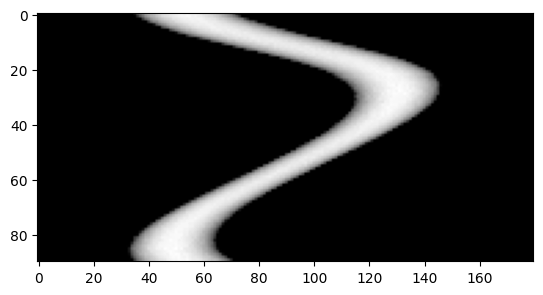

In [59]:
length=180
detector_amount=180
alpha=4

sinogram, ray_lines = radon_transform(image_array, length, detector_amount, alpha)
plt.imshow(sinogram, cmap='gray')

plt.show()

# Filter sinogram

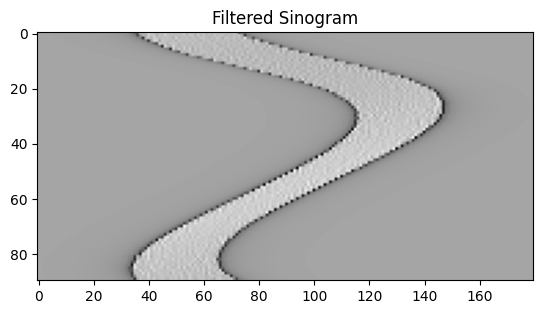

In [60]:
def filter_sinogram(sinogram):
    
    sinogram_shape = np.shape(sinogram)
    num_projections = sinogram_shape[0]
    num_detectors = sinogram_shape[1]
    filtered = np.zeros_like(sinogram)
    mask_size = math.floor(num_detectors / 2)
    mask = np.zeros(mask_size)
    center = math.floor(mask_size / 2)

    for i in range(0, mask_size, 1):
        k = i - center
        if k % 2 != 0:
            mask[i] = (-4 / np.pi ** 2) / k ** 2
    mask[center] = 1

    for proj_idx in range(num_projections):
        filtered[proj_idx] = sciSig.fftconvolve(sinogram[proj_idx], mask, mode='same')

    return filtered


filtered_sinogram = filter_sinogram(sinogram)

plt.figure()
plt.imshow(filtered_sinogram, cmap='gray')
plt.title('Filtered Sinogram')
plt.show()

# Get output image from filtered sinogram

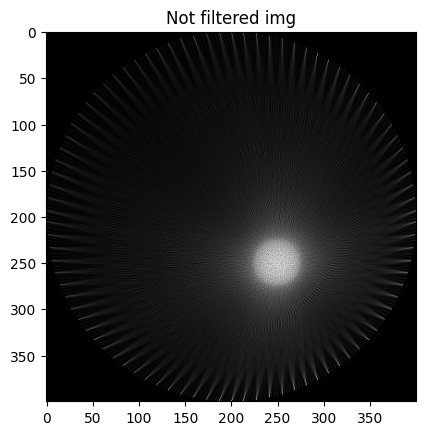

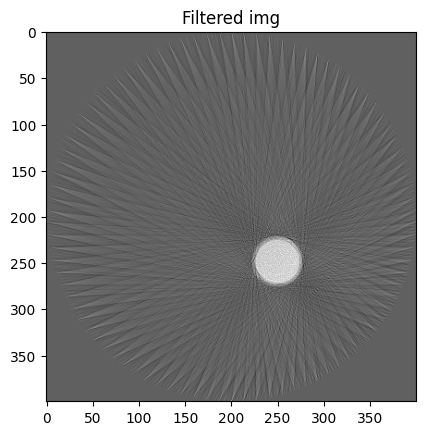

In [66]:
def get_output_img(image, sinogram, lines, filtr_option):
    projection = []
    if filtr_option:
        sinogram = filtered_sinogram
    
    width, height = np.shape(image)[0], np.shape(image)[1]
    number_of_projections, number_of_detectors = np.shape(sinogram)[0], np.shape(sinogram)[1]
    images_iteration = []
    output = np.zeros(shape=np.shape(image))
    helper = np.zeros(shape=np.shape(image))

    for projection in range(0, number_of_projections, 1):
        for detector in range(0, number_of_detectors, 1):
            x0, y0, x1, y1 = lines[projection][detector]
            line = bresenham(x0, y0, x1, y1)
            value = sinogram[projection][detector]
            for i in range(0, len(line), 1):
                x, y = line[i]
                if 0 <= x < width and 0 <= y < height:
                    output[int(x)][int(y)] += value
                    helper[int(x)][int(y)] += 1
        images_iteration.append(output.copy())

    return output, images_iteration


output_img, iteration_imgs = get_output_img(image_array, sinogram, ray_lines, False)
plt.imshow(output_img, cmap='gray')
plt.title('Not filtered img')
plt.show()

output_img.max()
output_img, iteration_imgs = get_output_img(image_array, sinogram, ray_lines, True)
plt.imshow(output_img, cmap='gray')
plt.title('Filtered img')
plt.show()